In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from hailo_sdk_client import ClientRunner, InferenceContext

chosen_hw_arch = "hailo8l"
model_name = "my_model_h8l"

2025-02-28 06:21:07.063985: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 06:21:07.337314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 06:21:07.988034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Model parameters
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Prepare the dataset
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(f"Total number of training samples: {x_train.shape[0]}")
print(f"Total number of testing samples: {x_test.shape[0]}")

Total number of training samples: 50000
Total number of testing samples: 10000


In [3]:
# Define the model
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

2025-02-28 06:21:12.774456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:21:12.851412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:21:12.851450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:21:12.854443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:21:12.854474: I tensorflow/compile

In [4]:
# Run short training (using only 5k images)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train[:5000], y_train[:5000], batch_size=128, epochs=1)

# Evaluate the results
score = model.evaluate(x_train, y_train)
print(f"Train accuracy: {100 * score[1]:.3f} (Top-1)")
score = model.evaluate(x_test, y_test)
print(f"Test accuracy: {100 * score[1]:.3f} (Top-1)")

2025-02-28 06:21:13.588231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8906
2025-02-28 06:21:13.920751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-28 06:21:13.984637: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fdb4403c880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-28 06:21:13.984675: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-02-28 06:21:14.018158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-28 06:21:14.238707: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

1563/1563 [==============================] - 4s 2ms/step - loss: 2.2049 - accuracy: 0.1837
Train accuracy: 18.374 (Top-1)
313/313 [==============================] - 1s 4ms/step - loss: 2.2057 - accuracy: 0.1845
Test accuracy: 18.450 (Top-1)


In [5]:
# Export the model to TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_path = f"{model_name}.tflite"
with tf.io.gfile.GFile(tflite_model_path, "wb") as f:
  f.write(tflite_model)

2025-02-28 06:21:17.031035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2304]
	 [[{{node inputs}}]]
2025-02-28 06:21:17.135754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2304]
	 [[{{node inputs}}]]
2025-02-28 06:21:17.497570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-02-28 06:21:17.497599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-02-28 06:21:17.498209: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedM

In [6]:
# Parse the TFlite model
runner = ClientRunner(hw_arch=chosen_hw_arch)
runner.translate_tf_model(tflite_model_path)

# Optimize the model: enforce 60% 4-bit weights without optimization
model_script_commands = [
    "model_optimization_config(compression_params, auto_4bit_weights_ratio=0.6)\n"
    "model_optimization_flavor(optimization_level=0)\n",
]

runner.load_model_script("".join(model_script_commands))
runner.optimize(x_train[:1024])

[info] Translation started on Tensorflow model model
[info] Start nodes mapped from original model: 'serving_default_input_1:0': 'model/input_layer1'.
[info] End nodes mapped from original model: 'StatefulPartitionedCall:0'.
[info] Translation completed on Tensorflow model model (completion time: 00:00:00.02)


2025-02-28 06:21:17.650088: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-02-28 06:21:17.660371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:21:17.660432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:21:17.660448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:21:17.660724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] co

[info] Loading model script commands to model from string
[info] Starting Model Optimization
[warning] Reducing compression level to 0 because requested optimization level equal or less than 1
[warning] Running model optimization with zero level of optimization is not recommended for production use and might lead to suboptimal accuracy results
[info] Model received quantization params from the hn


2025-02-28 06:21:17.949065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-02-28 06:21:18.009240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] MatmulDecompose skipped
[info] Starting Mixed Precision
[info] Assigning 4bit weights to layer model/conv2 with 18.43k parameters
[info] Ratio of weights in 4bit is 0.07
[info] Model Optimization Algorithm Mixed Precision is done (completion time is 00:00:00.02)
[info] LayerNorm Decomposition skipped
[info] Starting Statistics Collector
[info] Using dataset with 64 entries for calibration


Calibration:   0%|                                                                          | 0/64 [00:00<?, ?entries/s]2025-02-28 06:21:18.749442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-02-28 06:21:18.765931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
Calibration:   2%|█                                                                 | 1/64 [00:02<02:20,  2.23s/entries]2025-02-28 06:21:20.822955: I tensorflow/core/common_runtime/executor.cc:1197] [/devic

2025-02-28 06:21:21.024372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
Calibration:  44%|████████████████████████████▍                                    | 28/64 [00:02<00:01, 18.58entries/s]2025-02-28 06:21:21.031462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
2025-02-28 06:21:21.038799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore 

2025-02-28 06:21:21.225284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
2025-02-28 06:21:21.230942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
Calibration:  88%|████████████████████████████████████████████████████████▉        | 56/64 [00:02<00:00, 44.33entries/s]2025-02-28 06:21:21.237853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore 

[info] Model Optimization Algorithm Statistics Collector is done (completion time is 00:00:02.82)
[info] Starting Fix zp_comp Encoding
[info] Model Optimization Algorithm Fix zp_comp Encoding is done (completion time is 00:00:00.00)
[info] Matmul Equalization skipped
[info] No shifts available for layer model/fc1/conv_op, using max shift instead. delta=3.6361
[info] No shifts available for layer model/fc1/conv_op, using max shift instead. delta=1.8180
[info] Finetune encoding skipped
[info] Bias Correction skipped
[info] Adaround skipped
[info] Quantization-Aware Fine-Tuning skipped


2025-02-28 06:21:21.974285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] Layer Noise Analysis skipped
[info] The calibration set seems to not be normalized, because the values range is [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)].
Since the neural core works in 8-bit (between 0 to 255), a quantization will occur on the CPU of the runtime platform.
Add a normalization layer to the model to offload the normalization to the neural core.
Refer to the user guide Hailo Dataflow Compiler user guide / Model Optimization / Optimization Related Model Script Commands / model_modification_commands / normalization for details.
[info] Model Optimization is done


2025-02-28 06:21:22.370753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


In [7]:
# Evaluate the results
with runner.infer_context(InferenceContext.SDK_QUANTIZED) as q_ctx:
    with runner.infer_context(InferenceContext.SDK_FP_OPTIMIZED) as fp_ctx:
        y_infer_fp = runner.infer(fp_ctx, x_test)
        y_infer_q = runner.infer(q_ctx, x_test)

full_precision_result = np.count_nonzero(np.argmax(y_infer_fp, axis=-1) == np.argmax(y_test, axis=-1)) / len(y_test)
quantize_result = np.count_nonzero(np.argmax(y_infer_q, axis=-1) == np.argmax(y_test, axis=-1)) / len(y_test)
print(f"Test accuracy (floating point): {100 * full_precision_result:.3f} (Top-1)")
print(f"Test accuracy (quantized): {100 * quantize_result:.3f} (Top-1)")
print(f"Degradation: {100 * (full_precision_result - quantize_result):.3f}")

[info] Using 1 GPU for inference


2025-02-28 06:21:22.575940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
Inference: 0entries [00:00, ?entries/s]2025-02-28 06:21:22.671690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Inference: 10000entries [00:01, 5097.78entries/s]


[info] Using 1 GPU for inference


2025-02-28 06:21:24.646835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
Inference: 0entries [00:00, ?entries/s]2025-02-28 06:21:24.784484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Inference: 10000entries [00:05, 1976.02entries/s]


Test accuracy (floating point): 100000.000 (Top-1)
Test accuracy (quantized): 100000.000 (Top-1)
Degradation: 0.000


Epoch 1/10


2025-02-28 06:21:31.035524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]
2025-02-28 06:21:31.189405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]
2025-02-28 06:21:33.152968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSelectV2_8-2-TransposeNHWCToNCHW-LayoutOptimizer


391/391 [==============================] - 8s 12ms/step - loss: 4.5008 - accuracy: 0.1825
Epoch 2/10
 10/391 [..............................] - ETA: 4s - loss: 4.4974 - accuracy: 0.2133

2025-02-28 06:21:39.215418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 12ms/step - loss: 4.4992 - accuracy: 0.2034
Epoch 3/10
 10/391 [..............................] - ETA: 4s - loss: 4.4956 - accuracy: 0.2422

2025-02-28 06:21:44.145864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 12ms/step - loss: 4.4978 - accuracy: 0.2186
Epoch 4/10
 10/391 [..............................] - ETA: 4s - loss: 4.4938 - accuracy: 0.2508

2025-02-28 06:21:49.126113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 13ms/step - loss: 4.4963 - accuracy: 0.2265
Epoch 5/10
  9/391 [..............................] - ETA: 5s - loss: 4.4929 - accuracy: 0.2561

2025-02-28 06:21:54.202176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 14ms/step - loss: 4.4949 - accuracy: 0.2265
Epoch 6/10
  9/391 [..............................] - ETA: 5s - loss: 4.4913 - accuracy: 0.2465

2025-02-28 06:21:59.673464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 14ms/step - loss: 4.4934 - accuracy: 0.2230
Epoch 7/10
  9/391 [..............................] - ETA: 5s - loss: 4.4896 - accuracy: 0.2535

2025-02-28 06:22:05.147462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 14ms/step - loss: 4.4921 - accuracy: 0.2212
Epoch 8/10
  9/391 [..............................] - ETA: 5s - loss: 4.4880 - accuracy: 0.2465

2025-02-28 06:22:10.638172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 13ms/step - loss: 4.4908 - accuracy: 0.2193
Epoch 9/10
  9/391 [..............................] - ETA: 5s - loss: 4.4865 - accuracy: 0.2491

2025-02-28 06:22:16.002386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 13ms/step - loss: 4.4896 - accuracy: 0.2184
Epoch 10/10
  9/391 [..............................] - ETA: 5s - loss: 4.4851 - accuracy: 0.2483

2025-02-28 06:22:21.357977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,1,1,100]
	 [[{{node Placeholder/_1}}]]


391/391 [==============================] - 5s 13ms/step - loss: 4.4884 - accuracy: 0.2183


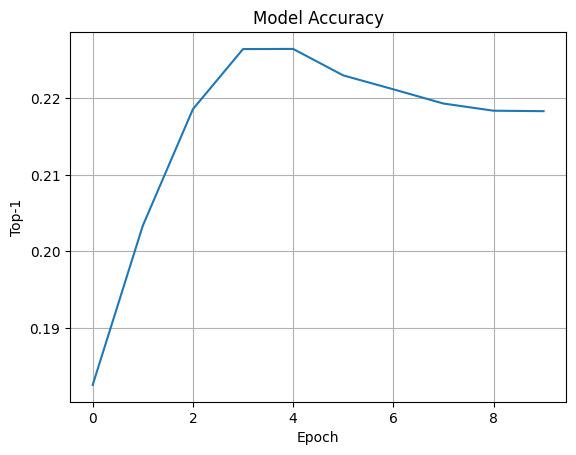

In [8]:
with tf.distribute.MultiWorkerMirroredStrategy().scope():
    with runner.infer_context(InferenceContext.SDK_QUANTIZED) as ctx:
        # get the Hailo Keras model for training
        model = runner.get_keras_model(ctx, trainable=True)

        # add external post-processing
        new_model = tf.keras.Sequential(
            [
                model,
                tf.keras.layers.Softmax(),
            ],
        )

        # adding external loss.
        # note that this compile API only compiles the Keras model but doesn't compile the model to the Hailo HW.
        new_model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
            metrics=["accuracy"],
        )

        # Hailo Keras model is exported with rank4 layers, expands dimensions for the y_train to match the model output shape
        y_train = np.expand_dims(y_train, axis=[1, 2])

        # move numpy data to tf.data.Dataset to be used by multiple GPUs
        train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_data = train_data.batch(128)
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
        train_data = train_data.with_options(options)

        # start QAT
        log = new_model.fit(train_data, batch_size=128, epochs=10)

        # set the Keras model after training. The model is already optimized, so do not run optimize() again.
        runner.set_keras_model(model)

# plot training curve
plt.plot(log.history["accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Top-1")
plt.xlabel("Epoch")
plt.grid()
plt.show()

In [9]:
# Evaluate the results
with runner.infer_context(InferenceContext.SDK_QUANTIZED) as q_ctx:
    y_infer_qat = runner.infer(q_ctx, x_test)

qat_result = np.count_nonzero(np.argmax(y_infer_qat, axis=-1) == np.argmax(y_test,axis=-1)) / len(y_test)
print(f"Test accuracy (quantized) before QAT: {100 * quantize_result:.3f} (Top-1)")
print(f"Test accuracy (quantized) after QAT: {100 * qat_result:.3f} (Top-1)")
print(f"Accuracy improvement: {100 * (qat_result - quantize_result):.3f}")

[info] Using 1 GPU for inference


2025-02-28 06:22:26.995983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
Inference: 0entries [00:00, ?entries/s]2025-02-28 06:22:27.126918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Inference: 10000entries [00:04, 2224.84entries/s]

Test accuracy (quantized) before QAT: 100000.000 (Top-1)
Test accuracy (quantized) after QAT: 100000.000 (Top-1)
Accuracy improvement: 0.000


In [10]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self._teacher = teacher
        self._student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super().compile(optimizer=optimizer, metrics=metrics)
        self._student_loss_fn = student_loss_fn
        self._distillation_loss_fn = distillation_loss_fn
        self._alpha = alpha
        self._temperature = temperature

    def train_step(self, data):
        # unpack data (image, label)
        x, y = data

        # forward pass of teacher
        teacher_predictions = self._teacher(x, training=False)

        with tf.GradientTape() as tape:
            # forward pass of student
            student_predictions = self._student(x, training=True)

            # compute supervised loss
            student_loss = self._student_loss_fn(y, student_predictions)

            # compute distillation loss
            distillation_loss = (
                self._distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self._temperature, axis=1),
                    tf.nn.softmax(student_predictions / self._temperature, axis=1),
                )
                * self._temperature**2
            )

            total_loss = self._alpha * student_loss + (1 - self._alpha) * distillation_loss

        # compute gradients
        trainable_vars = self._student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update the metrics
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"total_loss": total_loss, "student_loss": student_loss, "distillation_loss": distillation_loss},
        )
        return results

In [11]:
# Parse the TFlite model
runner = ClientRunner(hw_arch=chosen_hw_arch)
runner.translate_tf_model(tflite_model_path)

# Optimize the model: enforce 40% 4bit weights without optimization
model_script_commands = [
    "model_optimization_config(compression_params, auto_4bit_weights_ratio=0.6)\n"
    "model_optimization_flavor(optimization_level=0)\n",
]

runner.load_model_script("".join(model_script_commands))
runner.optimize(x_train[:1024])

with runner.infer_context(InferenceContext.SDK_QUANTIZED) as ctx_q:
    with runner.infer_context(InferenceContext.SDK_FP_OPTIMIZED) as ctx_fp:
        # get the Hailo Keras model for training
        student = runner.get_keras_model(ctx_q, trainable=True)

        # geth the full precision model for kd
        teacher = runner.get_keras_model(ctx_fp, trainable=False)

        # create the kd model
        distiller = Distiller(student=student, teacher=teacher)
        distiller.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
            student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
            distillation_loss_fn=tf.keras.losses.KLDivergence(),
            alpha=0.1,
            temperature=10,
        )

        # start QAT
        log = distiller.fit(x_train, y_train, batch_size=128, epochs=10)

        # set the Keras model after training
        runner.set_keras_model(student)

[info] Translation started on Tensorflow model model
[info] Start nodes mapped from original model: 'serving_default_input_1:0': 'model/input_layer1'.
[info] End nodes mapped from original model: 'StatefulPartitionedCall:0'.
[info] Translation completed on Tensorflow model model (completion time: 00:00:00.02)


2025-02-28 06:22:31.703499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-02-28 06:22:31.715537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:22:31.715600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:22:31.715618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-28 06:22:31.715858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] co

[info] Loading model script commands to model from string
[info] Starting Model Optimization
[warning] Reducing compression level to 0 because requested optimization level equal or less than 1
[warning] Running model optimization with zero level of optimization is not recommended for production use and might lead to suboptimal accuracy results
[info] Model received quantization params from the hn


2025-02-28 06:22:32.022364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] MatmulDecompose skipped
[info] Starting Mixed Precision
[info] Assigning 4bit weights to layer model/conv2 with 18.43k parameters
[info] Ratio of weights in 4bit is 0.07


2025-02-28 06:22:32.066709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] Model Optimization Algorithm Mixed Precision is done (completion time is 00:00:00.02)
[info] LayerNorm Decomposition skipped
[info] Starting Statistics Collector
[info] Using dataset with 64 entries for calibration


Calibration:   0%|                                                                          | 0/64 [00:00<?, ?entries/s]2025-02-28 06:22:32.471305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-02-28 06:22:32.488672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
Calibration:   2%|█                                                                 | 1/64 [00:00<00:40,  1.55entries/s]2025-02-28 06:22:32.965570: I tensorflow/core/common_runtime/executor.cc:1197] [/devic

2025-02-28 06:22:33.167413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
Calibration:  42%|███████████████████████████▍                                     | 27/64 [00:00<00:00, 45.51entries/s]2025-02-28 06:22:33.177009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
2025-02-28 06:22:33.185458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore 

2025-02-28 06:22:33.373945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
Calibration:  86%|███████████████████████████████████████████████████████▊         | 55/64 [00:01<00:00, 83.33entries/s]2025-02-28 06:22:33.383702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,32,32,3]
	 [[{{node Placeholder/_0}}]]
2025-02-28 06:22:33.391235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore 

[info] Model Optimization Algorithm Statistics Collector is done (completion time is 00:00:01.22)
[info] Starting Fix zp_comp Encoding
[info] Model Optimization Algorithm Fix zp_comp Encoding is done (completion time is 00:00:00.00)
[info] Matmul Equalization skipped
[info] No shifts available for layer model/fc1/conv_op, using max shift instead. delta=3.6361
[info] No shifts available for layer model/fc1/conv_op, using max shift instead. delta=1.8180


2025-02-28 06:22:34.101274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] Finetune encoding skipped
[info] Bias Correction skipped
[info] Adaround skipped
[info] Quantization-Aware Fine-Tuning skipped
[info] Layer Noise Analysis skipped
[info] The calibration set seems to not be normalized, because the values range is [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)].
Since the neural core works in 8-bit (between 0 to 255), a quantization will occur on the CPU of the runtime platform.
Add a normalization layer to the model to offload the normalization to the neural core.
Refer to the user guide Hailo Dataflow Compiler user guide / Model Optimization / Optimization Related Model Script Commands / model_modification_commands / normalization for details.


2025-02-28 06:22:34.772721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] Model Optimization is done
Epoch 1/10


2025-02-28 06:22:37.846577: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSelectV2_8-2-TransposeNHWCToNCHW-LayoutOptimizer


391/391 [==============================] - 8s 14ms/step - total_loss: 0.2196 - student_loss: 2.1955 - distillation_loss: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 5s 13ms/step - total_loss: 0.2183 - student_loss: 2.1832 - distillation_loss: 0.0000e+00
Epoch 3/10
391/391 [==============================] - 5s 13ms/step - total_loss: 0.2174 - student_loss: 2.1745 - distillation_loss: 0.0000e+00
Epoch 4/10
391/391 [==============================] - 5s 13ms/step - total_loss: 0.2167 - student_loss: 2.1673 - distillation_loss: 0.0000e+00
Epoch 5/10
391/391 [==============================] - 5s 13ms/step - total_loss: 0.2161 - student_loss: 2.1609 - distillation_loss: 0.0000e+00
Epoch 6/10
391/391 [==============================] - 5s 13ms/step - total_loss: 0.2154 - student_loss: 2.1542 - distillation_loss: 0.0000e+00
Epoch 7/10
391/391 [==============================] - 5s 13ms/step - total_loss: 0.2148 - student_loss: 2.1475 - distillation_loss: 0.0000e+00
Epoch 8/10

In [12]:
# Evaluate the results
with runner.infer_context(InferenceContext.SDK_QUANTIZED) as q_ctx:
    y_infer_qat = runner.infer(q_ctx, x_test)

qat_with_kd_result = np.count_nonzero(np.argmax(y_infer_qat, axis=-1) == np.argmax(y_test, axis=-1)) / len(y_test)
print(f"Test accuracy (quantized) with QAT: {100 * qat_result:.3f} (Top-1)")
print(f"Test accuracy (quantized) with QAT and KD: {100 * qat_with_kd_result:.3f} (Top-1)")
print(f"Accuracy improvement: {100 * (qat_with_kd_result - qat_result):.3f}")

[info] Using 1 GPU for inference


2025-02-28 06:23:29.893590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1279] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
Inference: 0entries [00:00, ?entries/s]2025-02-28 06:23:30.030397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Inference: 10000entries [00:00, 18374.46entries/s]

Test accuracy (quantized) with QAT: 100000.000 (Top-1)
Test accuracy (quantized) with QAT and KD: 100000.000 (Top-1)
Accuracy improvement: 0.000


In [13]:
hef = runner.compile()

file_name = f"{model_name}.hef"
with open(file_name, "wb") as f:
    f.write(hef)

[info] To achieve optimal performance, set the compiler_optimization_level to "max" by adding performance_param(compiler_optimization_level=max) to the model script. Note that this may increase compilation time.
[info] Loading network parameters
[info] Starting Hailo allocation and compilation flow
[info] Using Single-context flow
[info] Resources optimization guidelines: Strategy -> GREEDY Objective -> MAX_FPS
[info] Resources optimization params: max_control_utilization=75%, max_compute_utilization=75%, max_compute_16bit_utilization=75%, max_memory_utilization (weights)=75%, max_input_aligner_utilization=75%, max_apu_utilization=75%
[info] Using Single-context flow
[info] Resources optimization guidelines: Strategy -> GREEDY Objective -> MAX_FPS
[info] Resources optimization params: max_control_utilization=75%, max_compute_utilization=75%, max_compute_16bit_utilization=75%, max_memory_utilization (weights)=75%, max_input_aligner_utilization=75%, max_apu_utilization=75%
[info] input_l

[info] Context:0/0 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1  V          V          *          *          *          *          *          *          V       
 worker2  *          *          *          *          *          *          *          *          V       
 worker3  V          V          *          *          *          *          *          *          V       

  00:00
[info] Context:0/0 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1  V          V          *          *          *          *          *          *          V       
 worker2  *  

In [14]:
har_path = f"{model_name}_compiled_model.har"
runner.save_har(har_path)
!hailo profiler {har_path}

[info] Saved HAR to: /local/workspace/share/hailo/my_model_h8l_compiled_model.har
[info] Current Time: 06:23:35, 02/28/25
[info] CPU: Architecture: x86_64, Model: 13th Gen Intel(R) Core(TM) i7-13700F, Number Of Cores: 24, Utilization: 0.6%
[info] Memory: Total: 15GB, Available: 10GB
[info] System info: OS: Linux, Kernel: 5.15.167.4-microsoft-standard-WSL2
[info] Hailo DFC Version: 3.30.0
[info] HailoRT Version: 4.20.0
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo profiler my_model_h8l_compiled_model.har`
[info] Running profile for model in state compiled_model
[info] 
Model Details
--------------------------------  ----------
Input Tensors Shapes              32x32x3
Operations per Input Tensor       0.01 GOPs
Operations per Input Tensor       0.00 GMACs
Pure Operations per Input Tensor  0.01 GOPs
Pure Operations per Input Tensor  0.00 GMACs
Model Parameters                  0.27 M
--------------------------------  ----------

Profiler Input Settings
---------------